# Predicting the Sale Price of Bulldozers Using ML

## 1. Data: 
https://www.kaggle.com/competitions/playground-series-s3e13/data

There are 3 main datasets:
* 
Train.c v - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including SalePrice which is the target variable

* .
Valid.csv - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as Train.csv
* ).
Test.csv - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the SalePrice attribute, as this is what we'll be trying to predict).

## 2. Evaluation:
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction pri
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluationces.

## 3. Features:
[Google Sheets Lihttps://docs.google.com/spreadsheets/d/12EvLt9Zls4Kffcla583rqnuxOtRQaBYm2zCu--ouQ1I/edit#gid=10214219561956)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [30]:
# Import training and validation dataset
df = pd.read_csv('../../DataSets/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])
df_dup = df.copy()

## Preprocessing the data

In [31]:
# Function for converting String and Object values to categoricals

def convert_to_category(df):
    """
    Get data and convert string and on=bjects to category type.
    """
    
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype('category').cat.as_ordered()
    
    for label, content in df.items():
        if pd.api.types.is_object_dtype(content):
            df[label] = content.astype('category').cat.as_ordered()
    return df

In [32]:
# Function for filling missing values (numbers or category)

def fill_missing_numeric_values(df):
    """
    Fill missing Numerical values into numbers.
    
    Input: DataFrame
    Output: New DataFrame
    """
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Fill missing numeric values with median
                df[label] = content.fillna(content.mean())
                # add a binary column which tells us if the data is missing
                df[label + '_is_null'] = pd.isnull(content)
    return df


# Filling and turning Categorical variables into numbers

def fill_category_values(df):
    """
    Filling and turning Categorical variables into numbers
    
    Input: DataFrame
    Output: New DataFrame
    """
    
    for label, content in df.items():
        # Fill categorical features values into Numbers    
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate the sample has missing or not
            df[label + '_is_missing'] = pd.isnull(content)
            # Turn category into Number and add 1 to it (+1)
            df[label] = pd.Categorical(content).codes + 1
    return df

In [33]:
# Make the `saledate` feature more manageable in the future
df_dup['Year'] = df_dup['saledate'].dt.year
df_dup['Month'] = df_dup['saledate'].dt.month
df_dup['Day'] = df_dup['saledate'].dt.day
df_dup['Age'] = df_dup['Year'] - df_dup['YearMade']
df_dup.drop(['saledate'], axis=1, inplace=True)

# Use function for converting features to Category type
df_dup = convert_to_category(df_dup)

# Fill the missing Numerical Variables with median
df_dup = fill_missing_numeric_values(df_dup)
df_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 58 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   SalesID                           412698 non-null  int64   
 1   SalePrice                         412698 non-null  float64 
 2   MachineID                         412698 non-null  int64   
 3   ModelID                           412698 non-null  int64   
 4   datasource                        412698 non-null  int64   
 5   auctioneerID                      412698 non-null  float64 
 6   YearMade                          412698 non-null  int64   
 7   MachineHoursCurrentMeter          412698 non-null  float64 
 8   UsageBand                         73670 non-null   category
 9   fiModelDesc                       412698 non-null  category
 10  fiBaseModel                       412698 non-null  category
 11  fiSecondaryDesc                   27197

In [34]:
# Split data into train and validation
df_train = df_dup[df_dup['Year'] != 2012]
df_validation = df_dup[df_dup['Year'] == 2012]
len(df_train), len(df_validation)

(401125, 11573)

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

## Visualization

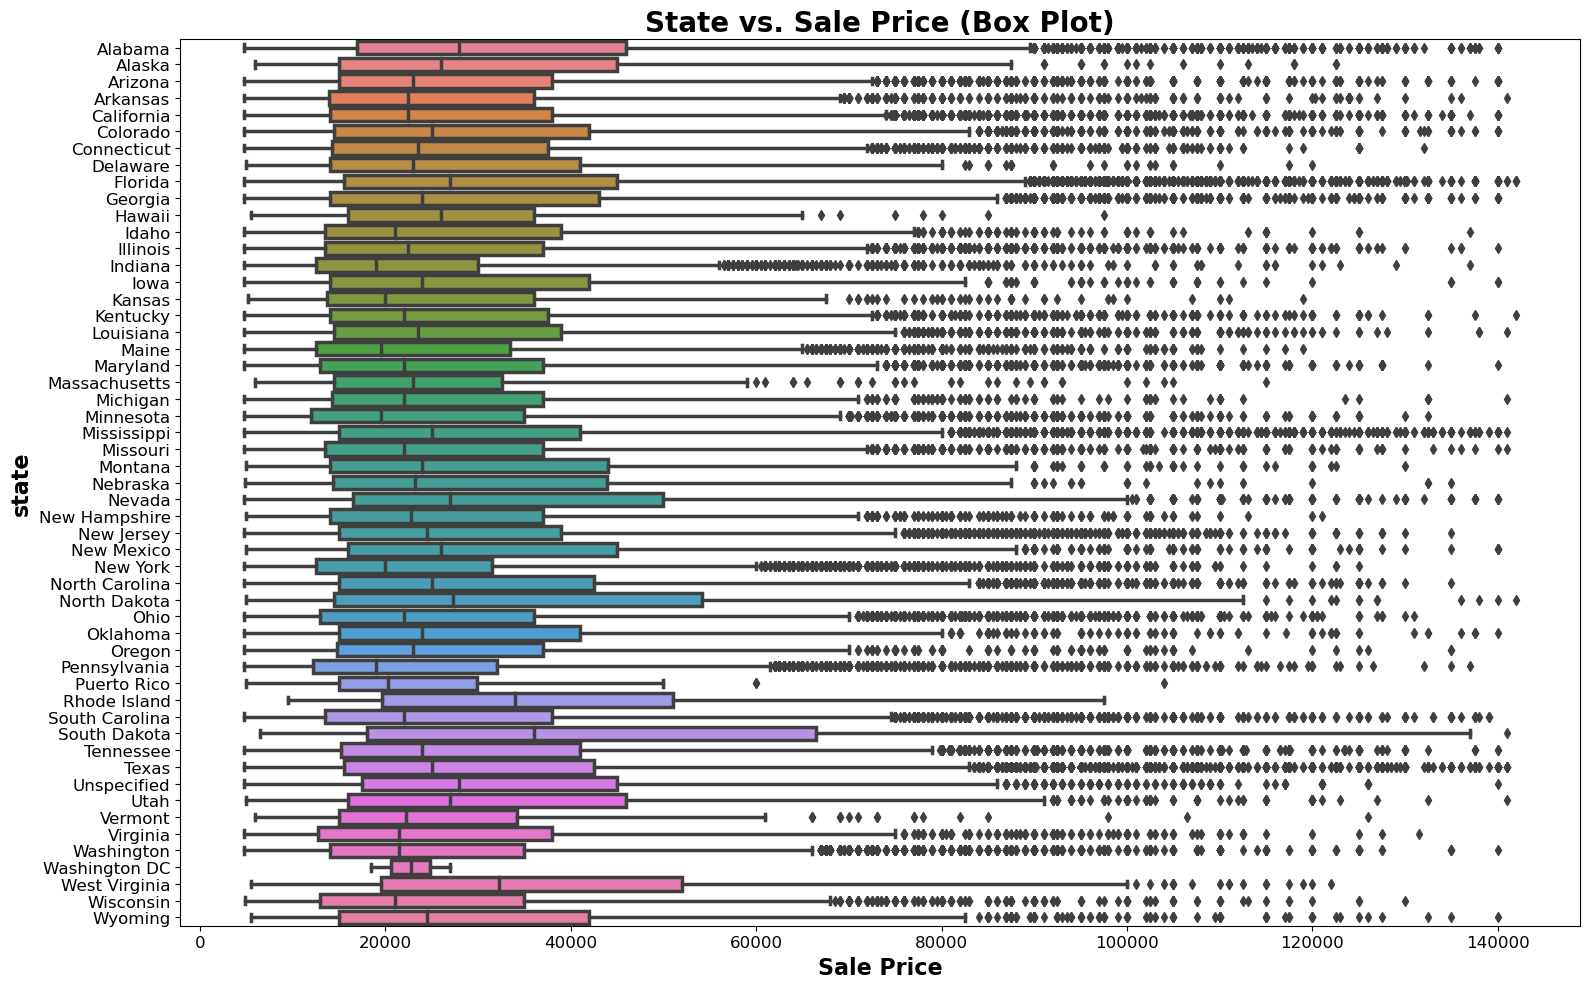

In [35]:
plt.figure(figsize=(16, 10))
custom_polette = sns.color_palette("husl", n_colors=len(df_train['state'].unique()))
sns.boxplot(x='SalePrice', y='state', data=df_train, palette=custom_polette, orient='h', linewidth=2.5)
plt.title('State vs. Sale Price (Box Plot)', fontsize=20, fontweight='bold')
plt.xlabel('Sale Price', fontsize=16, fontweight='bold')
plt.ylabel('state', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

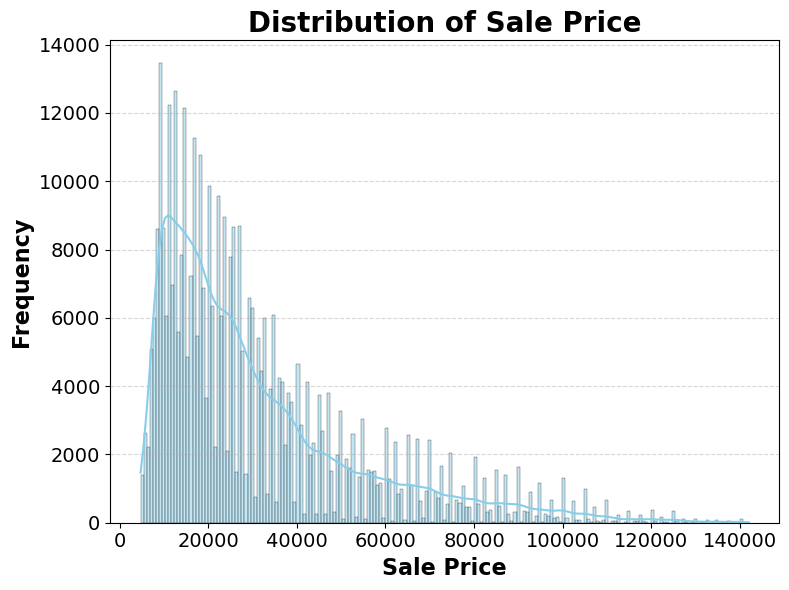

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='SalePrice', kde=True, color='skyblue' )
plt.title("Distribution of Sale Price", fontsize=20, fontweight='bold')
plt.xlabel('Sale Price', fontsize=16, fontweight='bold')
plt.ylabel('Frequency', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

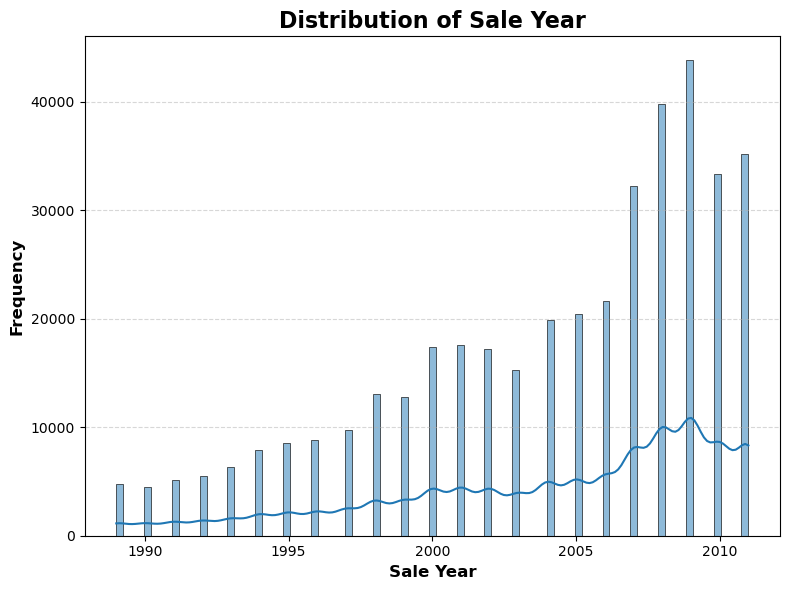

In [37]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_train, x='Year', kde=True)
plt.title("Distribution of Sale Year", fontsize=16, fontweight='bold')
plt.xlabel('Sale Year', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

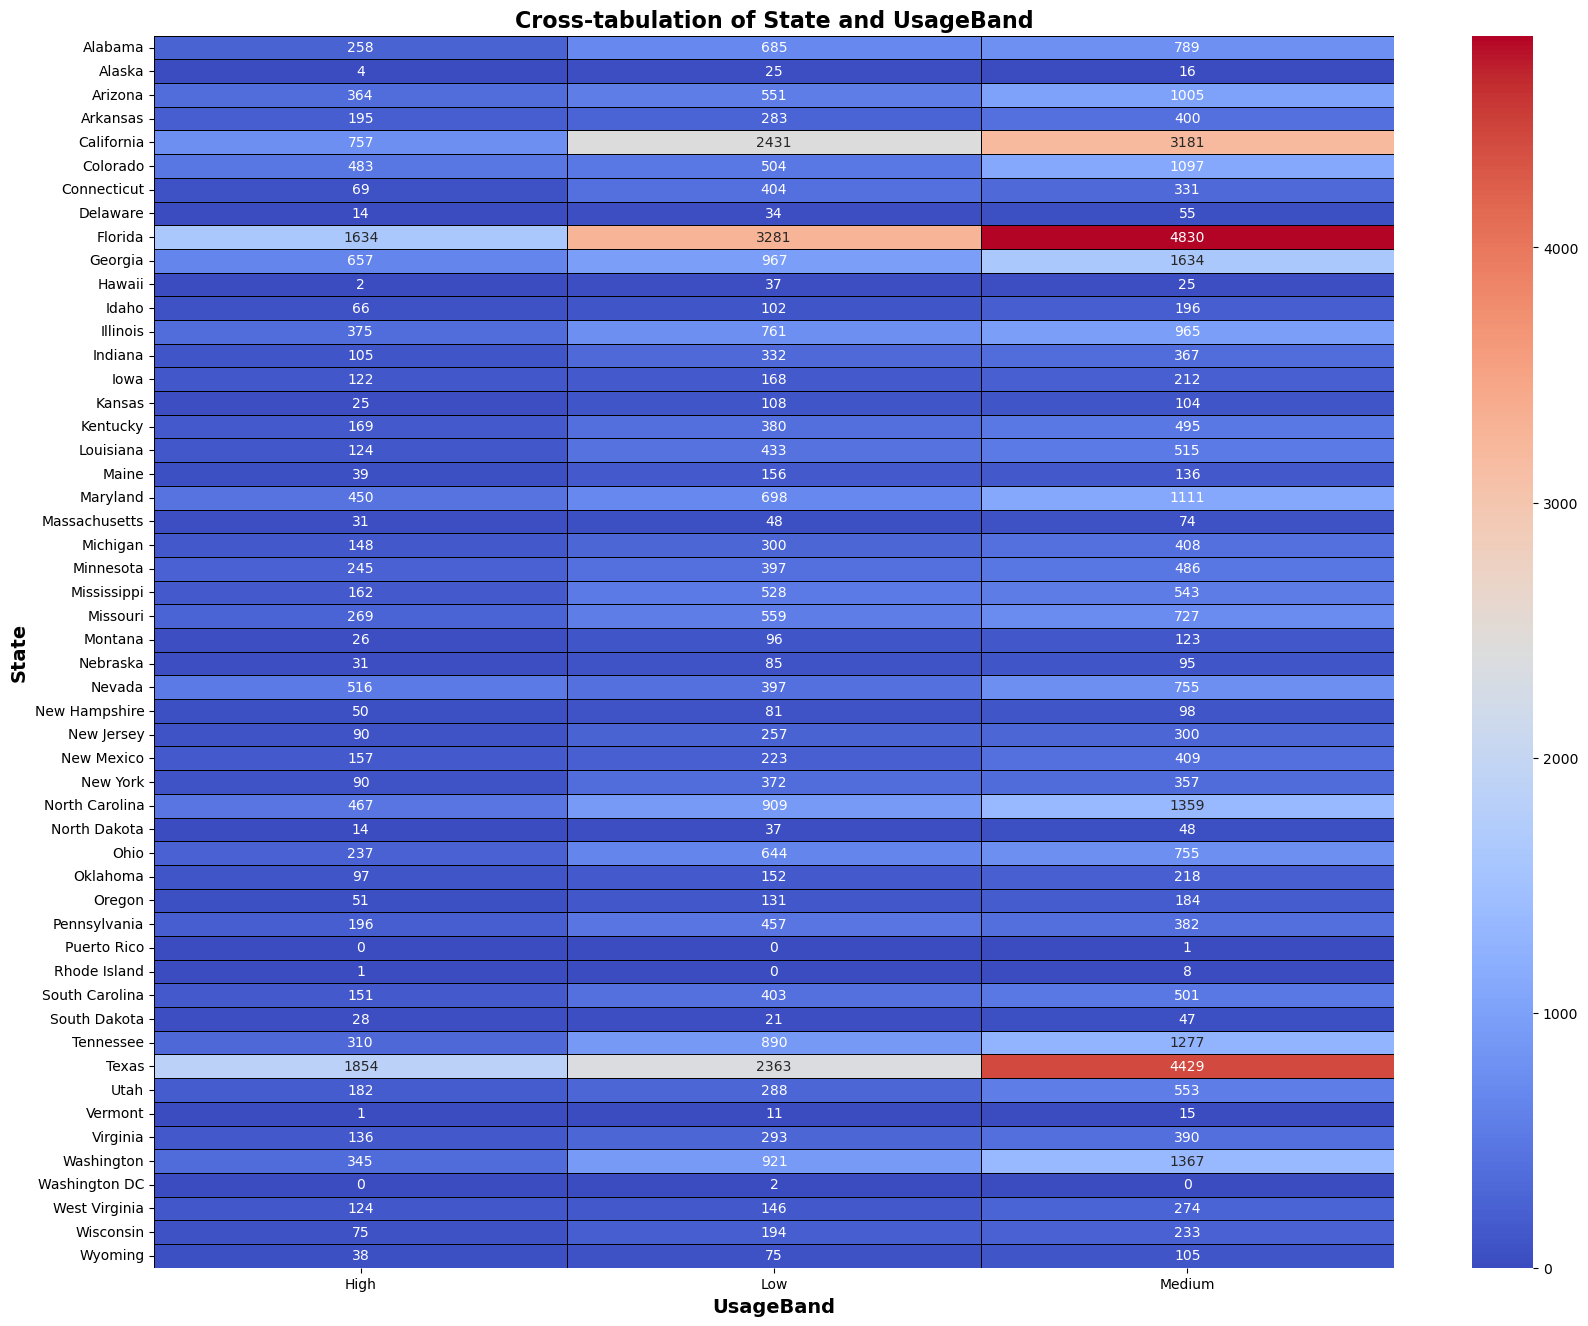

In [38]:
cross_tab = pd.crosstab(df_train['state'], df_train['UsageBand'])

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(cross_tab, cmap='coolwarm', annot=True, fmt='d', cbar=True, linewidths=0.5, linecolor='black')
plt.xlabel('UsageBand', fontsize=14, fontweight='bold')
plt.ylabel('State', fontsize=14, fontweight='bold')
plt.title('Cross-tabulation of State and UsageBand', fontsize=16, fontweight='bold')
plt.show()

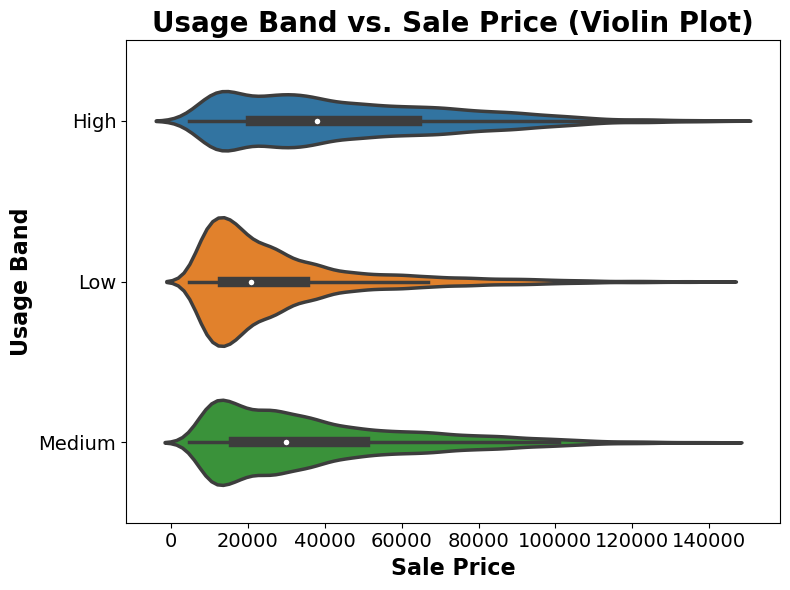

In [39]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='SalePrice', y='UsageBand', data=df_train, orient='h', linewidth=2.5)
plt.title("Usage Band vs. Sale Price (Violin Plot)", fontsize=20, fontweight='bold')
plt.xlabel('Sale Price', fontsize=16, fontweight='bold')
plt.ylabel('Usage Band', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

https://www.kaggle.com/code/sakethyalamanchili/machine-learning-for-bulldozer-prices

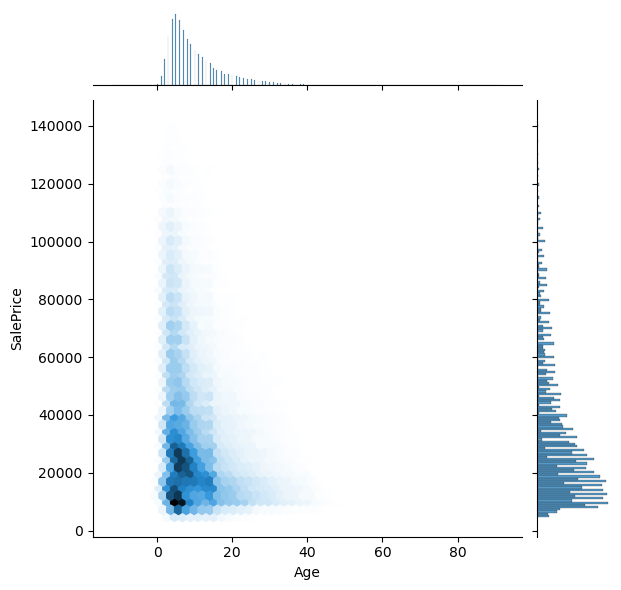

In [40]:
filtered_df = df_train[df_train['Age'] < 200]
sns.jointplot(data=filtered_df, x='Age', y='SalePrice', kind="hex")

In [43]:
# Filling and turning categorical variables into numbers in df_train and df_validation
df_train = fill_category_values(df_train)
df_validation = fill_category_values(df_validation)

In [44]:
# Split data into X and y
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_validation, y_validation = df_validation.drop('SalePrice', axis=1), df_validation['SalePrice']
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((401125, 101), (401125,), (11573, 101), (11573,))

### Building evaluation functions

In [45]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
def rmsle(y_true, y_pred):
    """
    Calculate root mean squared log error between predictions true labels.
    """
    return np.sqrt(mean_squared_log_error(y_true=y_true, y_pred=y_pred))

# Create a function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_validation)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Validation MAE": mean_absolute_error(y_validation, valid_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "Validation RMSLE": rmsle(y_validation, valid_preds),
        "Training R2": r2_score(y_train, train_preds),
        "Validation R2": r2_score(y_validation, valid_preds),
    }
    return scores

## RandomForestRegressor Model

In [16]:
from sklearn.ensemble import RandomForestRegressor
import time
start_time = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)
end_time = time.time()
print(f"{end_time - start_time : .2f}")

 0.00


In [17]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: total: 47.3 s
Wall time: 6.64 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [18]:
show_scores(model)

{'Training MAE': 5464.340385291367,
 'Validation MAE': 7339.609241337596,
 'Training RMSLE': 0.25349923154340015,
 'Validation RMSLE': 0.28955886121047625,
 'Training R2': 0.8660420567765259,
 'Validation R2': 0.8185699182494517}

### Hyperparameter tuning with RandomizedSearchCV

In [19]:
# Different RandomForestRegressor hyperparameters
param_dict = {
    'n_estimators': np.arange(40, 200, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(5, 110, 5)),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'bootstrap': [True, False]
}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions=param_dict,
                              n_iter=5,
                              cv=5,
                              verbose=True)

# Fit the randomized search to the data
rs_model.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = rs_model.best_params_
best_score = rs_model.best_score_
print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
Best cross-validation score: 0.80


### Train a model with the best hyperparamters¶

In [20]:
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(
    n_estimators= best_params['n_estimators'],
    min_samples_split= best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    bootstrap = best_params['bootstrap']
)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

 # Scores for ideal model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 3842.145291172696,
 'Validation MAE': 6440.785420532227,
 'Training RMSLE': 0.1850369982329035,
 'Validation RMSLE': 0.2587022448352011,
 'Training R2': 0.9340965690083591,
 'Validation R2': 0.8594186377025264}

## 2- XGBoost Model

In [47]:
import xgboost as xgb
import numpy as np
import time

# Convert data into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_validation, y_validation)

# Set parameters based on best_params
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'eta': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.75,
    'min_child_weight': 1,
    'gamma': 0,
    'lambda': 1,    # L2 regularization term on weights
    'alpha': 0.1    # L1 regularization term on weights
}

# Number of boosting round 
num_round = 1000

# Train the model with cross-validation
start_time = time.time()
cv_results = xgb.cv(params=params, dtrain=dtrain, num_boost_round=num_round, nfold=5, early_stopping_rounds=50, metrics="rmse", as_pandas=True, seed=42)
end_time = time.time()
print(f"Cross-validation time: {end_time - start_time:.2f} seconds")

# Get the number of boosting rounds from cross-validation
best_num_round = cv_results.shape[0]

# Train the model
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=best_num_round)

Cross-validation time: 718.24 seconds


In [48]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
def rmsle(y_true, y_pred):
    """
    Calculate root mean squared log error between predictions true labels.
    """
    return np.sqrt(mean_squared_log_error(y_true=y_true, y_pred=y_pred))

# Create a function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(dtrain)
    valid_preds = model.predict(dtest)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Validation MAE": mean_absolute_error(y_validation, valid_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "Validation RMSLE": rmsle(y_validation, valid_preds),
        "Training R2": r2_score(y_train, train_preds),
        "Validation R2": r2_score(y_validation, valid_preds),
    }
    return scores

In [49]:
# Scores for the XGBoost model
show_scores(xgb_model)

{'Training MAE': 3972.918557091627,
 'Validation MAE': 6121.035485494929,
 'Training RMSLE': 0.19721074827152615,
 'Validation RMSLE': 0.25089138663381955,
 'Training R2': 0.9315581751004065,
 'Validation R2': 0.8737029441275488}

### Suggestions for Further Improvement
### 1. Feature Engineering:

- Analyze feature importance and possibly create new features or remove irrelevant ones.
- Consider interaction features or polynomial features.

### 2. Model Ensemble:

- Combine predictions from different models, such as XGBoost and RandomForest, using ensemble techniques like stacking or blending.

### 3. Data Augmentation:

- Augment the data by adding more samples or creating synthetic data points using techniques like SMOTE.

### 4. Model Hyperparameter Refinement:
- Further refine hyperparameters based on insights from feature importance or cross-validation results.
Use Bayesian Optimization or Hyperopt for hyperparameter tuning.

### 5. Regularization:

- Increase the regularization parameters (lambda and alpha) to further reduce overfitting.

### 6. Validation Strategy:

- Ensure that the validation strategy (e.g., K-fold cross-validation) is appropriate for the data and the problem.

## 2-1- Advanced Hyperparameter Tuning with Bayesian Optimization

In [ ]:
pip install bayesian-optimization

In [53]:
# from bayes_opt import BayesianOptimization
# import xgboost as xgb
# from sklearn.metrics import mean_squared_log_error

# # Function to calculate RMSLE
# def rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

# # Function to train and evaluate XGBoost model
# def xgb_evaluate(max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda):
#     params = {
#         'objective': 'reg:squarederror',
#         'max_depth': int(max_depth),
#         'learning_rate': learning_rate,
#         'subsample': subsample,
#         'colsample_bytree': colsample_bytree,
#         'min_child_weight': min_child_weight,
#         'gamma': gamma,
#         'reg_alpha': reg_alpha,
#         'reg_lambda': reg_lambda
#     }
#     cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, metrics="rmse", early_stopping_rounds=50)
#     return -cv_result['test-rmse-mean'].min()  # We return negative value to maximize

# # Bayesian Optimization
# xgb_bo = BayesianOptimization(
#     f=xgb_evaluate,
#     pbounds={
#         'max_depth': (3, 15),
#         'learning_rate': (0.01, 0.3),
#         'subsample': (0.6, 1.0),
#         'colsample_bytree': (0.6, 1.0),
#         'min_child_weight': (1, 10),
#         'gamma': (0, 0.5),
#         'reg_alpha': (0, 1.0),
#         'reg_lambda': (1, 3)
#     },
#     random_state=42,
#     verbose=2
# )

# xgb_bo.maximize(init_points=10, n_iter=50)

# # Get the best parameters
# best_params = xgb_bo.max['params']
# best_params['max_depth'] = int(best_params['max_depth'])

# # Train the final model with the best parameters
# final_model = xgb.XGBRegressor(**best_params)
# final_model.fit(X_train, y_train)

# # Scores for the final XGBoost model
# scores = show_scores(final_model)
# print(scores)

### A Guide on XGBoost hyperparameters tuning
 
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

### Bayesian Optimization using Hyperopt

https://www.kaggle.com/code/prashant111/bayesian-optimization-using-hyperopt


### Save the XGBOost Model

In [55]:
# Save the best model using pickle
import pickle

with open('../../DataSets/bluebook-for-bulldozers/MySavedData/XGBoost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

In [56]:
show_scores(xgb_model)

{'Training MAE': 3972.918557091627,
 'Validation MAE': 6121.035485494929,
 'Training RMSLE': 0.19721074827152615,
 'Validation RMSLE': 0.25089138663381955,
 'Training R2': 0.9315581751004065,
 'Validation R2': 0.8737029441275488}

## 2-2- Feature Engineering


In [ ]:
# Feature Engineering
from sklearn.preprocessing import PolynomialFeatures

# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_validation_poly = poly.transform(X_validation)

# Train the model with polynomial features
final_model_poly = xgb.XGBRegressor(**best_params)
final_model_poly.fit(X_train_poly, y_train)

# Scores for the final XGBoost model with polynomial features
scores_poly = show_scores(final_model_poly)
print(scores_poly)

## 2-3- Model Ensemble

In [ ]:
# Model Ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

# Train individual models
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Ensemble models using VotingRegressor
ensemble_model = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model)
])
ensemble_model.fit(X_train, y_train)

# Scores for the ensemble model
scores_ensemble = show_scores(ensemble_model)
print(scores_ensemble)


### Make prediction on test data

In [90]:
# Import the test data
df_test = pd.read_csv('../../DataSets/bluebook-for-bulldozers/Test.csv', low_memory=False, parse_dates=['saledate'])
df_test

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0      1227829    1006309     3168         121             3      1999   
1      1227844    1022817     7271         121             3      1000   
2      1227847    1031560    22805         121             3      2004   
3      1227848      56204     1269         121             3      2006   
4      1227863    1053887    22312         121             3      2005   
...        ...        ...      ...         ...           ...       ...   
12452  6643171    2558317    21450         149             2      2008   
12453  6643173    2558332    21434         149             2      2005   
12454  6643184    2558342    21437         149             2      1000   
12455  6643186    2558343    21437         149             2      2006   
12456  6643196    2558346    21446         149             2      2008   

       MachineHoursCurrentMeter UsageBand   saledate fiModelDesc  ...  \
0                        3688.0       Low 2012-05-03        580G  ...   
1                       28555.0      High 2012-05-10         936  ...   
2                        6038.0    Medium 2012-05-10    EC210BLC  ...   
3                        8940.0      High 2012-05-10       330CL  ...   
4                        2286.0       Low 2012-05-10        650K  ...   
...                         ...       ...        ...         ...  ...   
12452                       NaN       NaN 2012-10-24       80NX3  ...   
12453                       NaN       NaN 2012-10-24         28N  ...   
12454                       NaN       NaN 2012-10-24         35N  ...   
12455                       NaN       NaN 2012-10-24         35N  ...   
12456                       NaN       NaN 2012-09-19        55N2  ...   

      Undercarriage_Pad_Width         Stick_Length                Thumb  \
0                         NaN                  NaN                  NaN   
1                         NaN                  NaN                  NaN   
2         None or Unspecified                9' 6"               Manual   
3         None or Unspecified  None or Unspecified               Manual   
4                         NaN                  NaN                  NaN   
...                       ...                  ...                  ...   
12452     None or Unspecified  None or Unspecified  None or Unspecified   
12453     None or Unspecified  None or Unspecified  None or Unspecified   
12454     None or Unspecified  None or Unspecified  None or Unspecified   
12455     None or Unspecified  None or Unspecified  None or Unspecified   
12456     None or Unspecified  None or Unspecified  None or Unspecified   

           Pattern_Changer Grouser_Type     Backhoe_Mounting Blade_Type  \
0                      NaN          NaN                  NaN        NaN   
1                      NaN          NaN                  NaN        NaN   
2      None or Unspecified       Double                  NaN        NaN   
3                      Yes       Triple                  NaN        NaN   
4                      NaN          NaN  None or Unspecified        PAT   
...                    ...          ...                  ...        ...   
12452  None or Unspecified       Double                  NaN        NaN   
12453  None or Unspecified       Double                  NaN        NaN   
12454  None or Unspecified       Double                  NaN        NaN   
12455  None or Unspecified       Double                  NaN        NaN   
12456  None or Unspecified       Double                  NaN        NaN   

           Travel_Controls Differential_Type Steering_Controls  
0                      NaN               NaN               NaN  
1                      NaN          Standard      Conventional  
2                      NaN               NaN               NaN  
3                      NaN               NaN               NaN  
4      None or Unspecified               NaN               NaN  
...                    ...               ...     

### Preprocess the test dtat

In [91]:
# Make the `saledate` feature more manageable in the future
df_test['Year'] = df_test['saledate'].dt.year
df_test['Month'] = df_test['saledate'].dt.month
df_test['Day'] = df_test['saledate'].dt.day
df_test['Age'] = df_test['Year'] - df_test['YearMade']
df_test.drop(['saledate'], axis=1, inplace=True)

# Converting features to Category type
df_test = convert_to_category(df_test)

# Fill the missing Numerical Variables with median
df_test = fill_missing_numeric_values(df_test)

# Fill the categorical values with numbers
df_test = fill_category_values(df_test)
df_test

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0      1227829    1006309     3168         121             3      1999   
1      1227844    1022817     7271         121             3      1000   
2      1227847    1031560    22805         121             3      2004   
3      1227848      56204     1269         121             3      2006   
4      1227863    1053887    22312         121             3      2005   
...        ...        ...      ...         ...           ...       ...   
12452  6643171    2558317    21450         149             2      2008   
12453  6643173    2558332    21434         149             2      2005   
12454  6643184    2558342    21437         149             2      1000   
12455  6643186    2558343    21437         149             2      2006   
12456  6643196    2558346    21446         149             2      2008   

       MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                     3688.0000          2          499          180  ...   
1                    28555.0000          1          831          292  ...   
2                     6038.0000          3         1177          404  ...   
3                     8940.0000          1          287          113  ...   
4                     2286.0000          2          566          196  ...   
...                         ...        ...          ...          ...  ...   
12452                19846.7783          0          713          235  ...   
12453                19846.7783          0          186           80  ...   
12454                19846.7783          0          325          123  ...   
12455                19846.7783          0          325          123  ...   
12456                19846.7783          0          483          171  ...   

       Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                    True                     True   
1                                    True                     True   
2                                   False                    False   
3                                   False                    False   
4                                    True                     True   
...                                   ...                      ...   
12452                               False                    False   
12453                               False                    False   
12454                               False                    False   
12455                               False                    False   
12456                               False                    False   

       Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0                  True                        True                     True   
1                  True                        True                     True   
2                 False                       False                    False   
3                 False                       False                    False   
4                  True                        True                     True   
...                 ...                         ...                      ...   
12452             False                       False                    False   
12453             False                       False                    False   
12454             False                       False                    False   
12455             False                       False                    False   
12456             False                       False                    False   

       Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                             True                   True   
1                             True                   True   
2                             True                   True   
3                             True                   True   
4                            False                  False   
...                      

In [92]:
remaining_feature = list(set(X_train) - set(df_test))
print(remaining_feature)
for i in remaining_feature:
    df_test[i] = False

['auctioneerID_is_null']


In [99]:
# Ensure the order of columns in df_test matches X_train
df_test = df_test[X_train.columns]

# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds

array([16841.08351371, 18856.02365169, 41357.95321494, ...,
       19014.47085813, 28093.77432463, 28511.62527166])

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [100]:
df_preds = pd.DataFrame()
df_preds['SaleID'] = df_test['SalesID']
df_preds['SalePrice'] = test_preds
df_preds

SaleID     SalePrice
0      1227829  16841.083514
1      1227844  18856.023652
2      1227847  41357.953215
3      1227848  52701.414156
4      1227863  45247.952139
...        ...           ...
12452  6643171  37294.316018
12453  6643173  22228.187068
12454  6643184  19014.470858
12455  6643186  28093.774325
12456  6643196  28511.625272

[12457 rows x 2 columns]